In [1]:
from math import sqrt
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.core import BasicSynthesizer, SeriesSynthesizer
from synthesized.core.values import CategoricalValue, ContinuousValue
from synthesized.testing.evaluation import Evaluation

os.getcwd()
evaluation = Evaluation(config_path='../synthesized/configs/evaluation/synthetic_distributions.json', name='synthetic')
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


In [3]:
def create_categorical_periodic_series(length):
    period = np.arange(4)
    xs = np.concatenate([np.tile(period, length // 4), period[:length % 4]])
    return pd.DataFrame({'x': xs})

In [4]:
def create_time_series_data(func, length):
    """
    Create a data frame of a time-series based on a time-series 
    function.
    
    :param func: {times: np.array[int]} -> np.array[float]]
                a function that takes a sequence of time steps and noise 
                and returns a series of values
    :param length: [int] number of time steps
    :return: pd.DataFrame{t[datetime], x[float]}
    """
    # create time columns
    times = np.arange(start=0, stop=length)
    
    # create value column
    xs = func(times)
    
    # cast times to date-time
    times = pd.to_datetime(times, unit="d")
    
    # combine
    df = pd.DataFrame({"t": times, "x": xs})
    return df

In [5]:
def additive_linear(a, b, sd):
    """
    A linear trend with additive noise
    :param a: [float] slope
    :param b: [float] intercept
    :param sd: [float] error standard deviation
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*times + b + eps
    return out_func


def additive_sine(a, p, sd):
    """
    A sinusoidal trend with additive noise
    :param a: [float] amplitude
    :param p: [float] period
    :param sd: [float] error standard deviation
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*np.sin(2*np.pi*times/p) + eps
    return out_func


def auto_regressive(phi, c, sd):
    """
    A linear autoregressive process of order k 
    i.e an AR(k) process
    :param phi: [np.array] regression weights
    :param c: [float] bias
    :param sd: [float] error standard deviation
    """
    k = phi.shape[0]
    
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        out_list = k*[0.]
        for i in range(times.shape[0]):
            # fetch regression context: previous k values
            x_prev = np.array(out_list[-k:][::-1])
            # sample next value
            x_t = c + (phi*x_prev).sum() + eps[i]
            out_list.append(x_t)
        return out_list[k:]
    return out_func


def add_series(*args):
    """
    Return a time series which is a sum of 
    several other time series.
    :param args: times series closures
    :return: time series closure
    """
    def out_func(times):
        series = [func(times) for func in args]
        return sum(series)
    return out_func

In [6]:
def rolling_mse_asof(data, synthesized, sd, time_unit=None):
    """
    Calculate the mean-squared error between the "x" values of the original and synthetic 
    data. The sets of times may not be identical so we use "as of" (last observation rolled 
    forward) to interpolate between the times in the two datasets.
    
    The dates are also optionally truncated to some unit following the syntax for the pandas 
    `.floor` function.
    
    :param data: [pd.DataFrame{id[int], t[datetime], x[float]}] original data
    :param synthesized: [pd.DataFrame{id[int], t[datetime], x[float]}] synthesized data
    :param sd: [float] error standard deviation
    :param time_unit: [str] the time unit to round to. See documentation for pandas `.floor` method.
    :return: [(float, float)] MSE and MSE/(2*error variance) 
    """
    # truncate date 
    if time_unit is not None:
        synthesized.t = synthesized.t.dt.floor(time_unit)
        data.t = data.t.dt.floor(time_unit)
    
    # join datasets
    joined = pd.merge_asof(data[["t", "x"]], synthesized[["t", "x"]], on="t")
    
    # calculate metrics
    mse = ((joined.x_x - joined.x_y)**2).mean()
    mse_eff = mse/(2*sd**2)
    
    return mse, mse_eff

In [7]:
def edit_distance(xs, ys):
    assert len(xs) == len(ys)
    distances = list(range(len(xs) + 1))
    for ny, y in enumerate(ys):
        next_distances = [ny + 1]
        for nx, x in enumerate(xs):
            if x == y:
                next_distances.append(distances[nx])
            else:
                next_distances.append(1 + min(
                    (distances[nx], distances[nx+1], next_distances[-1])
                ))
        distances = next_distances
        yield distances[ny + 1]

In [8]:
def plot_data(data, ax, value_types, series_length, target=None):
    if len(value_types) == 1:
        sns.lineplot(x=np.arange(series_length), y=data['x'][:series_length], ax=ax)
        if value_types['x'] is CategoricalValue:
            if target is not None:
                ax2 = ax.twinx()
                sns.lineplot(
                    x=np.arange(series_length),
                    y=list(edit_distance(data['x'][:series_length], target['x'][:series_length])),
                    ax=ax2, color='red'
                )
    elif len(value_types) == 2:
        if 't' in value_types:
            sns.lineplot(x=data['t'][:series_length], y=data['x'][:series_length], ax=ax)

In [9]:
def synthesize_and_plot(
    data, name, lstm_mode, series_length=100, identifier_label=None, num_iterations=None
):
    if num_iterations is None:
        num_iterations = evaluation.config['num_iterations']
    start = time.time()
    with SeriesSynthesizer(
        data=data, lstm_mode=lstm_mode, identifier_label=identifier_label, **evaluation.config['params']
    ) as synthesizer:
        print('value types:')
        for value in synthesizer.values:
            print(value.name, value)
        value_types = {value.name: type(value) for value in synthesizer.values}
        synthesizer.learn(data=data, num_iterations=num_iterations, verbose=250, print_data=5)
        print('took', time.time() - start, 's')
        synthesized = synthesizer.synthesize(num_series=1, series_length=series_length)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('original')
        ax2.set_title('synthesized')
        plot_data(data, ax=ax1, value_types=value_types, series_length=series_length)
        plot_data(synthesized, ax=ax2, value_types=value_types, series_length=series_length, target=data)

In [10]:
def series_synthesize_and_plot(
    data, name, lstm_mode, num_series, sd, time_unit, series_length=100,
    identifier_label=None, num_iterations=None
):
    if num_iterations is None:
        num_iterations = evaluation.config['num_iterations']
    start = time.time()
    with SeriesSynthesizer(
        data=data, identifier_label=identifier_label, lstm_mode=lstm_mode, **evaluation.config['params']
    ) as synthesizer:
        print('value types:')
        for value in synthesizer.values:
            print(value.name, value)
        value_types = {value.name: type(value) for value in synthesizer.values}
        synthesizer.learn(data=data, num_iterations=num_iterations, verbose=250, print_data=5)
        print('took', time.time() - start, 's')
        synthesized = synthesizer.synthesize(num_series=1, series_length=len(data))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('original')
        ax2.set_title('synthesized')
        plot_data(data, ax=ax1, value_types=value_types, series_length=series_length)
        plot_data(synthesized, ax=ax2, value_types=value_types, series_length=series_length)
        mse, mse_eff = rolling_mse_asof(data, synthesized, sd=sd, time_unit=time_unit)
        evaluation[f"{name}_mse"] = mse
        evaluation[f"{name}_mse_efficiency"] = mse_eff

### Time-series tests

In [11]:
data = create_categorical_periodic_series(length=1000)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
value types:
x categorical4-103

iteration: 1
loss: total=-1.19e+02 (encoding=13.513650894165039, x=-132.1083526611328, regularization=6.803208088967949e-05)
KS distances: avg=0.30 (x=0.30)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  2
1  1
2  1
3  0
4  0

iteration: 125
loss: total=-1.30e+02 (encoding=2.2712717056274414, x=-132.25502014160156, regularization=7.669737533433363e-05)
KS distances: avg=0.01 (x=0.01)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  0
1  1
2  2
3  3
4  0

iteration: 250
loss: total=-1.30e+02 (encoding=1.411950707435608, x=-131.2223358154297, regularization=8.352993609150872e-05)
KS distances: avg=0.00 (x=0.00)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  0
1  1
2  2
3  3
4  0

iteration: 500
loss: total=-1.31e+02 (enco

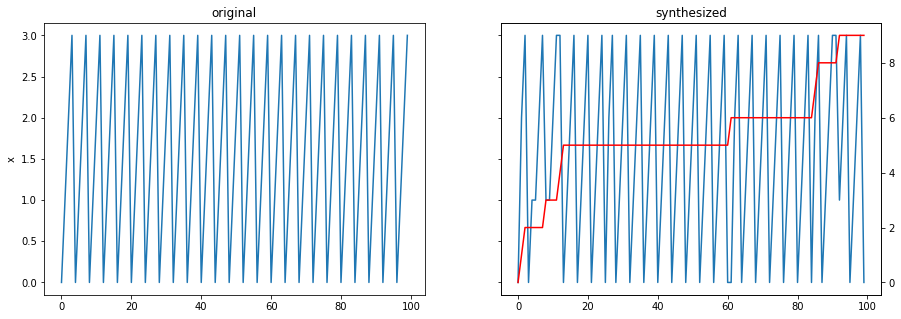

In [12]:
synthesize_and_plot(data, name="categorical_periodic_mode1", lstm_mode=1)

value types:
x categorical4-103

iteration: 1
loss: total=-1.32e+02 (encoding=0.013462393544614315, x=-132.07217407226562, regularization=6.728970765834674e-05)
KS distances: avg=0.30 (x=0.30)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  2
1  2
2  1
3  1
4  2

iteration: 125
loss: total=-1.36e+02 (encoding=0.0011051702313125134, x=-135.8292694091797, regularization=6.947262590983883e-05)
KS distances: avg=0.08 (x=0.08)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  2
1  1
2  1
3  1
4  1

iteration: 250
loss: total=-1.36e+02 (encoding=8.310849079862237e-05, x=-135.84107971191406, regularization=6.793111970182508e-05)
KS distances: avg=0.11 (x=0.11)
original data:
   x
0  0
1  1
2  2
3  3
4  0
synthesized data:
   x
0  2
1  2
2  2
3  2
4  0

iteration: 500
loss: total=-1.36e+02 (encoding=3.951806138502434e-05, x=-135.84068298339844, regularization=6.401073915185407e-05)
KS distances: avg=0.30 (x=0.30)
original data:
   x
0  0
1  1
2  2
3 

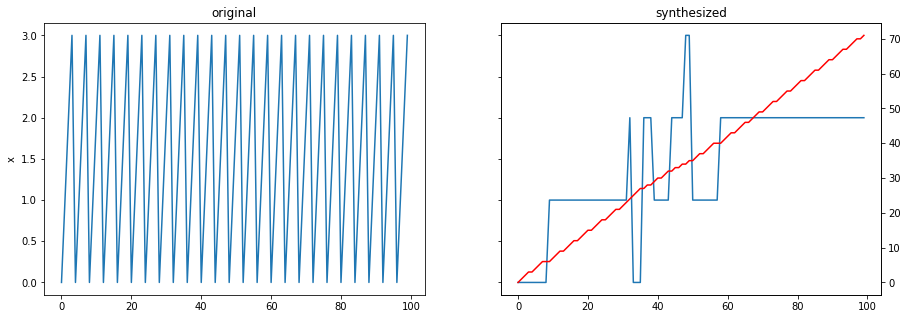

In [13]:
synthesize_and_plot(data, name="categorical_periodic_mode2", lstm_mode=2)

In [14]:
data = create_time_series_data(func=additive_linear(a=2., b=5., sd=1e-3), length=10000)

value types:
t date-dirac-timedelta
x continuous-uniform-positive

iteration: 1
loss: total=1.43e+01 (encoding=13.938097953796387, t=0.0, x=0.3122488856315613, regularization=0.00040464301127940416)
KS distances: avg=0.07 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.01, x=0.43)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      0     29       10  0.400997
1  1.0       0      1      0       11  0.401272
2  1.0       0      2      1       11  0.401547
3  1.0       0      3      2       11  0.401821
4  1.0       0      4      3       11  0.402096
synthesized data:
          t         x
0 -0.004177 -0.018295
1 -0.030095 -0.051276
2  0.000349  0.005887
3 -0.008566 -0.013070
4 -0.019108  0.045963

iteration: 125
loss: total=2.07e+00 (encoding=0.08283539116382599, t=0.0, x=1.990598201751709, regularization=0.00034261346445418894)
KS distances: avg=0.09 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.01, x=0.51)
original data:
     t  t-hour  

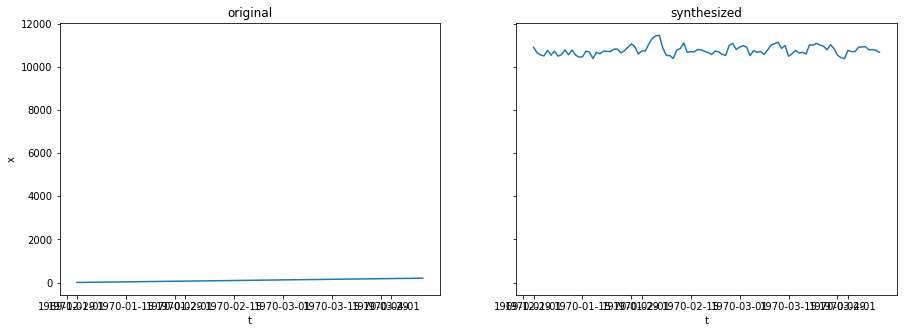

In [15]:
series_synthesize_and_plot(data, "trend_linear_mode1", lstm_mode=1, num_series=1, sd=1.0, time_unit="d")

value types:
t date-dirac-timedelta
x continuous-uniform-positive

iteration: 1
loss: total=8.20e-02 (encoding=0.0136612169444561, t=0.0, x=0.06789841502904892, regularization=0.00040452188113704324)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.01, x=0.46)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      1     22        9 -0.367016
1  1.0       0      2     23        9 -0.366745
2  1.0       0      3     24        9 -0.366474
3  1.0       0      4     25        9 -0.366203
4  1.0       0      5     26        9 -0.365933
synthesized data:
          t         x
0  0.465268  1.258019
1  0.650023  1.171077
2  0.413970  1.089786
3  0.132712  0.752812
4  0.061010  0.450926

iteration: 125
loss: total=1.93e-02 (encoding=0.0028113198932260275, t=0.0, x=0.016102418303489685, regularization=0.0003386220778338611)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.01, x=0.45)
original data:
     t  t-h

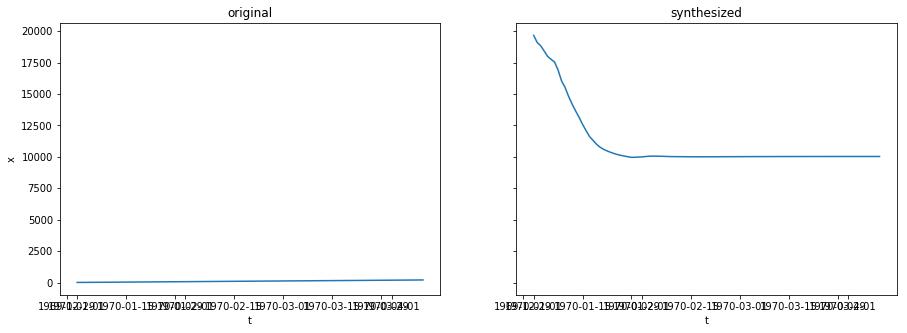

In [16]:
series_synthesize_and_plot(
    data, "trend_linear_mode2", lstm_mode=2, num_series=1, sd=1.0, time_unit="d"
)

In [17]:
data = create_time_series_data(func=additive_sine(a=10, p=1000, sd=1.), length=10000)

value types:
t date-dirac-timedelta
x continuous-uniform

iteration: 1
loss: total=1.47e+01 (encoding=13.762306213378906, t=0.0, x=0.9855595231056213, regularization=0.0004044253728352487)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.46)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      1     23        0 -0.201257
1  1.0       0      2     24        0 -0.281095
2  1.0       0      3     25        0  0.013996
3  1.0       0      4     26        0 -0.356969
4  1.0       0      5     27        0 -0.322503
synthesized data:
          t         x
0 -0.000547  0.012684
1 -0.029987  0.047948
2  0.007312 -0.026939
3 -0.057222 -0.076615
4 -0.091865 -0.030798

iteration: 125
loss: total=1.11e+00 (encoding=0.2116168886423111, t=0.0, x=0.8987472057342529, regularization=0.00034174619941040874)
KS distances: avg=0.07 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.44)
original data:
     t  t-hour  t-dow  t-d

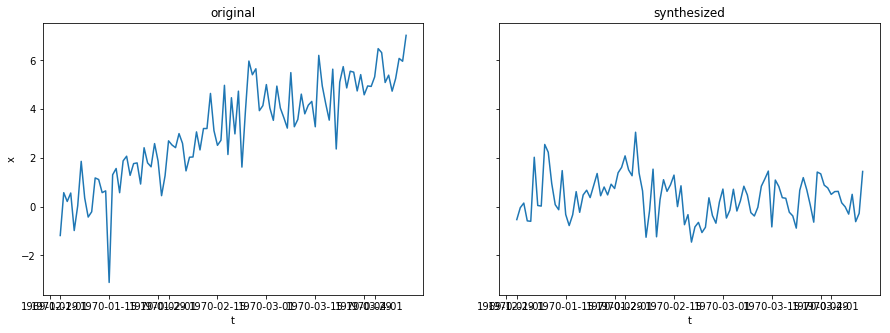

In [18]:
series_synthesize_and_plot(
    data, name="cyclical_sinusoidal_mode1", lstm_mode=1, num_series=1, sd=1., time_unit="d"
)

value types:
t date-dirac-timedelta
x continuous-uniform

iteration: 1
loss: total=9.82e-01 (encoding=0.013904914259910583, t=0.0, x=0.9676846265792847, regularization=0.0004043430380988866)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.46)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      0     10        7 -0.933216
1  1.0       0      1     11        7 -0.929074
2  1.0       0      2     12        7 -0.893894
3  1.0       0      3     13        7 -0.865881
4  1.0       0      4     14        7 -0.516590
synthesized data:
          t         x
0 -0.215641  0.583287
1 -0.188271  1.039053
2 -0.088790  1.105682
3  0.134383  0.936676
4  0.232071  0.887427

iteration: 125
loss: total=1.00e+00 (encoding=0.006803079042583704, t=0.0, x=0.9928687810897827, regularization=0.0003365867305546999)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.46)
original data:
     t  t-hour  t-dow  

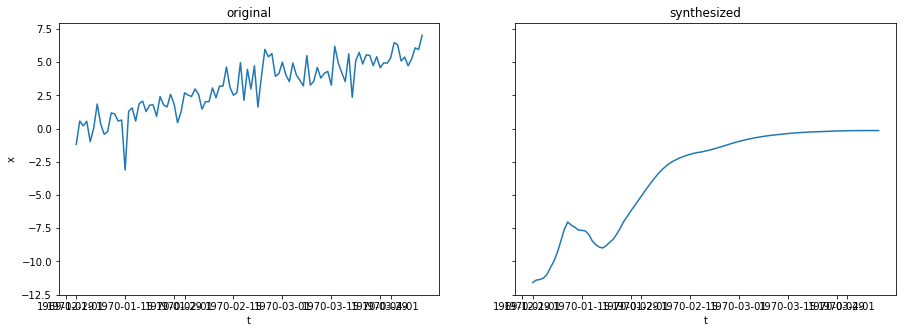

In [19]:
series_synthesize_and_plot(
    data, name="cyclical_sinusoidal_mode2", lstm_mode=2, num_series=1, sd=1., time_unit="d"
)

In [20]:
data = create_time_series_data(
    func=add_series(additive_sine(a=20, p=1000, sd=5.), additive_sine(a=5, p=200, sd=1.)),
    length=10000
)

value types:
t date-dirac-timedelta
x continuous-normal

iteration: 1
loss: total=1.48e+01 (encoding=13.737462043762207, t=0.0, x=1.0200514793395996, regularization=0.00040356063982471824)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.47)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      2      1       10  0.530957
1  1.0       0      3      2       10  0.124501
2  1.0       0      4      3       10  0.321925
3  1.0       0      5      4       10  0.456091
4  1.0       0      6      5       10  0.561708
synthesized data:
          t         x
0 -0.042328  0.059240
1 -0.031229  0.032455
2 -0.021796  0.009610
3  0.004599  0.005834
4  0.012251  0.115628

iteration: 125
loss: total=1.22e+00 (encoding=0.5080404281616211, t=0.0, x=0.7090834379196167, regularization=0.0003376264066901058)
KS distances: avg=0.07 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.42)
original data:
     t  t-hour  t-dow  t-da

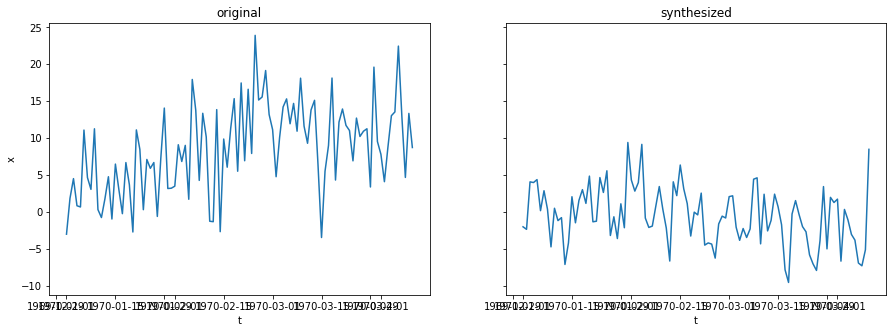

In [21]:
series_synthesize_and_plot(
    data, name='cyclical_and_seasonal_sinusoidal_mode1', lstm_mode=1,
    num_series=1, sd=sqrt(1.**2 + 5**2), time_unit="d"
)

value types:
t date-dirac-timedelta
x continuous-normal

iteration: 1
loss: total=1.01e+00 (encoding=0.013620404526591301, t=0.0, x=0.9980798959732056, regularization=0.0004044914385303855)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.47)
original data:
     t  t-hour  t-dow  t-day  t-month         x
0  1.0       0      6      3        6 -1.191880
1  1.0       0      0      4        6 -1.320039
2  1.0       0      1      5        6 -0.797113
3  1.0       0      2      6        6 -0.617774
4  1.0       0      3      7        6 -0.672361
synthesized data:
          t         x
0 -1.080249 -2.063160
1 -0.700600 -0.960951
2 -0.558323 -0.045391
3 -0.286648  0.190696
4 -0.059965  0.377347

iteration: 125
loss: total=1.08e+00 (encoding=0.009312635287642479, t=0.0, x=1.072901964187622, regularization=0.0003385246673133224)
KS distances: avg=0.08 (t=0.00, t-hour=0.00, t-dow=0.00, t-day=0.00, t-month=0.00, x=0.49)
original data:
     t  t-hour  t-dow  t-

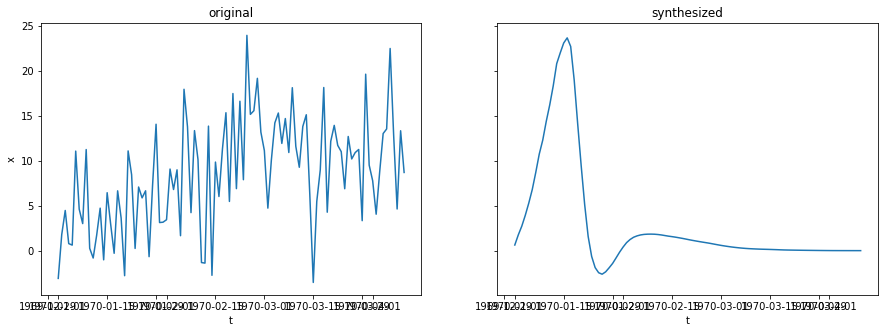

In [22]:
series_synthesize_and_plot(
    data, name='cyclical_and_seasonal_sinusoidal_mode2', lstm_mode=2,
    num_series=1, sd=sqrt(1.0 ** 2 + 5**2), time_unit="d"
)